In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import pandas as pd
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("spark").getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
21/12/08 15:22:38 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
df = spark.read.csv('diabetes_012_health_indicators_BRFSS2015.csv', header = True, inferSchema = True)

# Data Understanding
In this section of the code we will be attempting to understand the dataset that has been provided via Kaggle.
- https://www.kaggle.com/alexteboul/diabetes-health-indicators-dataset

In [3]:
df.show()

+------------+------+--------+---------+----+------+------+--------------------+------------+------+-------+-----------------+-------------+-----------+-------+--------+--------+--------+---+----+---------+------+
|Diabetes_012|HighBP|HighChol|CholCheck| BMI|Smoker|Stroke|HeartDiseaseorAttack|PhysActivity|Fruits|Veggies|HvyAlcoholConsump|AnyHealthcare|NoDocbcCost|GenHlth|MentHlth|PhysHlth|DiffWalk|Sex| Age|Education|Income|
+------------+------+--------+---------+----+------+------+--------------------+------------+------+-------+-----------------+-------------+-----------+-------+--------+--------+--------+---+----+---------+------+
|         0.0|   1.0|     1.0|      1.0|40.0|   1.0|   0.0|                 0.0|         0.0|   0.0|    1.0|              0.0|          1.0|        0.0|    5.0|    18.0|    15.0|     1.0|0.0| 9.0|      4.0|   3.0|
|         0.0|   0.0|     0.0|      0.0|25.0|   1.0|   0.0|                 0.0|         1.0|   0.0|    0.0|              0.0|          0.0|    

In [4]:
#Shape of the datadrame and counting the values in the Diabetes dataset.
print((df.count(),len(df.columns)))
df.groupby('Diabetes_012').count().show()

(253680, 22)


+------------+------+
|Diabetes_012| count|
+------------+------+
|         0.0|213703|
|         1.0|  4631|
|         2.0| 35346|
+------------+------+



In [94]:
df.printSchema()

root
 |-- Diabetes_012: double (nullable = true)
 |-- HighBP: double (nullable = true)
 |-- HighChol: double (nullable = true)
 |-- CholCheck: double (nullable = true)
 |-- BMI: double (nullable = true)
 |-- Smoker: double (nullable = true)
 |-- Stroke: double (nullable = true)
 |-- HeartDiseaseorAttack: double (nullable = true)
 |-- PhysActivity: double (nullable = true)
 |-- Fruits: double (nullable = true)
 |-- Veggies: double (nullable = true)
 |-- HvyAlcoholConsump: double (nullable = true)
 |-- AnyHealthcare: double (nullable = true)
 |-- NoDocbcCost: double (nullable = true)
 |-- GenHlth: double (nullable = true)
 |-- MentHlth: double (nullable = true)
 |-- PhysHlth: double (nullable = true)
 |-- DiffWalk: double (nullable = true)
 |-- Sex: double (nullable = true)
 |-- Age: double (nullable = true)
 |-- Education: double (nullable = true)
 |-- Income: double (nullable = true)



In [95]:
#Data cleaning
def dataCleaning(df,print_result):
    for col in df.columns:
        if print_result==True:
            print(col,":",df[df[col].isNull()].count())

In [96]:
print("Finding NULL values")
dataCleaning(df,True)

Finding NULL values


Diabetes_012 : 0
HighBP : 0
HighChol : 0
CholCheck : 0
BMI : 0
Smoker : 0
Stroke : 0
HeartDiseaseorAttack : 0
PhysActivity : 0
Fruits : 0
Veggies : 0
HvyAlcoholConsump : 0
AnyHealthcare : 0
NoDocbcCost : 0
GenHlth : 0
MentHlth : 0
PhysHlth : 0
DiffWalk : 0
Sex : 0
Age : 0
Education : 0
Income : 0


In [5]:
#Removing prediabetes from the dataset and replacing the diabetes value from 2 to 1
from pyspark.sql import functions as F
df1 = df.filter(df.Diabetes_012!=1.0)
df1.show()
df2 = df1.na.replace([2.0], [1.0], 'Diabetes_012')
df2.groupby('Diabetes_012').count().show()

+------------+------+--------+---------+----+------+------+--------------------+------------+------+-------+-----------------+-------------+-----------+-------+--------+--------+--------+---+----+---------+------+
|Diabetes_012|HighBP|HighChol|CholCheck| BMI|Smoker|Stroke|HeartDiseaseorAttack|PhysActivity|Fruits|Veggies|HvyAlcoholConsump|AnyHealthcare|NoDocbcCost|GenHlth|MentHlth|PhysHlth|DiffWalk|Sex| Age|Education|Income|
+------------+------+--------+---------+----+------+------+--------------------+------------+------+-------+-----------------+-------------+-----------+-------+--------+--------+--------+---+----+---------+------+
|         0.0|   1.0|     1.0|      1.0|40.0|   1.0|   0.0|                 0.0|         0.0|   0.0|    1.0|              0.0|          1.0|        0.0|    5.0|    18.0|    15.0|     1.0|0.0| 9.0|      4.0|   3.0|
|         0.0|   0.0|     0.0|      0.0|25.0|   1.0|   0.0|                 0.0|         1.0|   0.0|    0.0|              0.0|          0.0|    

In [9]:
for col in df.columns:
    print(col,":",df.stat.corr('Diabetes_012',col))

Diabetes_012 : 1.0
HighBP : 0.2715964243298824
HighChol : 0.20908491100576146
CholCheck : 0.06754647611600013
BMI : 0.2243794737583975
Smoker : 0.0629140950601668
Stroke : 0.10717866994339764
HeartDiseaseorAttack : 0.18027168633560287
PhysActivity : -0.12194716655035258
Fruits : -0.04219162985450684
Veggies : -0.058971599234704304
HvyAlcoholConsump : -0.05788191173818581
AnyHealthcare : 0.015410377239766794
NoDocbcCost : 0.03543568500155128
GenHlth : 0.3025866208859791
MentHlth : 0.07350676620655906
PhysHlth : 0.17628673570564043
DiffWalk : 0.22423912328804765
Sex : 0.031040163652105594
Age : 0.18502579410172637
Education : -0.1305169177115621
Income : -0.17148303762778558


In [10]:
df2.show()

+------------+------+--------+---------+----+------+------+--------------------+------------+------+-------+-----------------+-------------+-----------+-------+--------+--------+--------+---+----+---------+------+
|Diabetes_012|HighBP|HighChol|CholCheck| BMI|Smoker|Stroke|HeartDiseaseorAttack|PhysActivity|Fruits|Veggies|HvyAlcoholConsump|AnyHealthcare|NoDocbcCost|GenHlth|MentHlth|PhysHlth|DiffWalk|Sex| Age|Education|Income|
+------------+------+--------+---------+----+------+------+--------------------+------------+------+-------+-----------------+-------------+-----------+-------+--------+--------+--------+---+----+---------+------+
|         0.0|   1.0|     1.0|      1.0|40.0|   1.0|   0.0|                 0.0|         0.0|   0.0|    1.0|              0.0|          1.0|        0.0|    5.0|    18.0|    15.0|     1.0|0.0| 9.0|      4.0|   3.0|
|         0.0|   0.0|     0.0|      0.0|25.0|   1.0|   0.0|                 0.0|         1.0|   0.0|    0.0|              0.0|          0.0|    

# Explanatory Data Analysis

In [19]:
eda1 = df2.toPandas()

In [20]:
eda1.groupby('Diabetes_012').count()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
Diabetes_012,,,,,,,,,,,,,,,,,,,,,
0.0,213703,213703,213703,213703,213703,213703,213703,213703,213703,213703,...,213703,213703,213703,213703,213703,213703,213703,213703,213703,213703
1.0,35346,35346,35346,35346,35346,35346,35346,35346,35346,35346,...,35346,35346,35346,35346,35346,35346,35346,35346,35346,35346


/Users/rishisingh/.local/share/virtualenvs/spark_test-2CXUZLP8/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


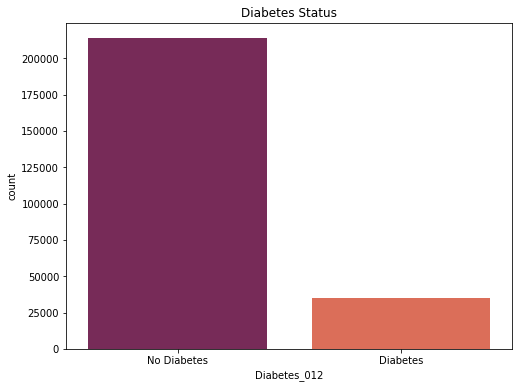

In [37]:
#visualize diabetes status
plt.figure(figsize = (8,6))
sns.countplot(eda1['Diabetes_012'], palette="rocket")
plt.title("Diabetes Status")
plt.show()

High correlation columns: Index(['Diabetes_012', 'HighBP', 'HighChol', 'BMI', 'GenHlth', 'DiffWalk'], dtype='object')


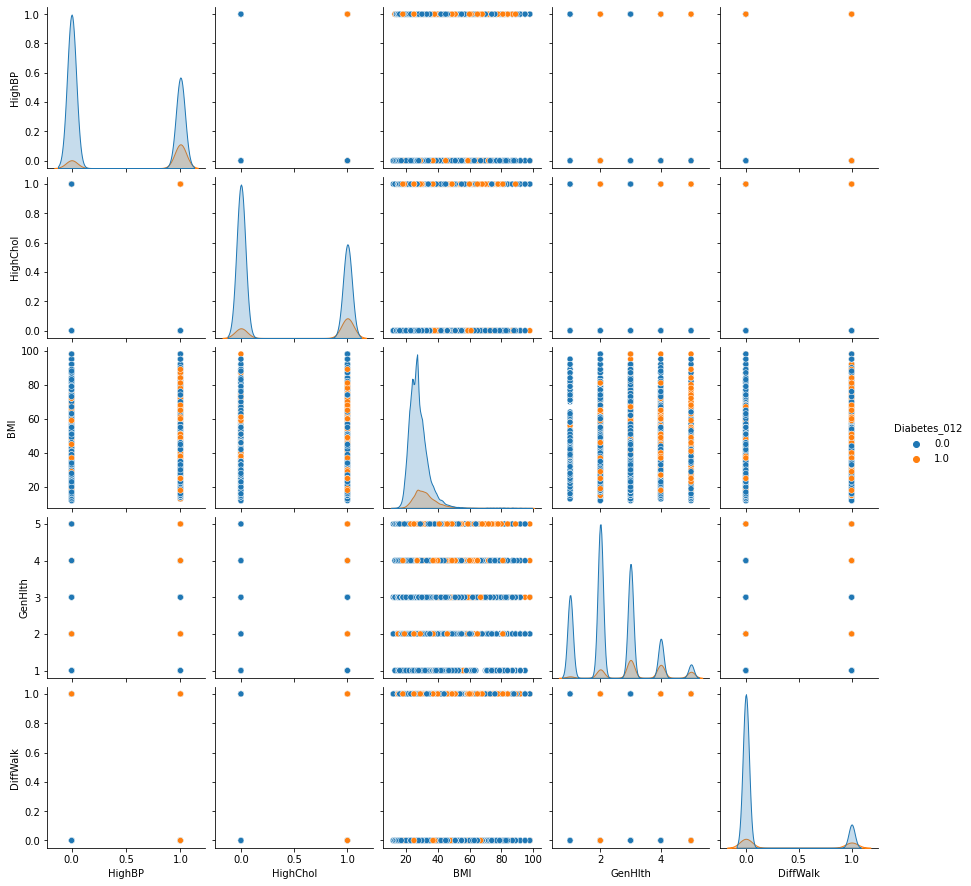

In [22]:
eda1.corr()['Diabetes_012']
max_corr = eda1.corr()['Diabetes_012'][eda1.corr()['Diabetes_012'] > 0.2].keys()

max_corr = eda1.corr()['Diabetes_012'][eda1.corr()['Diabetes_012'] > 0.2].keys()

print("High correlation columns:", max_corr)
max_corr_cols = max_corr[1:]

sns.pairplot(eda1, x_vars = max_corr_cols, y_vars = max_corr_cols, hue='Diabetes_012', height=2.5, palette="rocket")
plt.show()

In [45]:
eda2 = eda1
eda2.Diabetes_012[eda2['Diabetes_012'] == 0.0] = 'No Diabetes'
eda2.Diabetes_012[eda2['Diabetes_012'] == 1.0] = 'Diabetes'


eda2.HighBP[eda2['HighBP'] == 0.0] = 'No High'
eda2.HighBP[eda2['HighBP'] == 1.0] = 'High BP'

eda2.HighChol[eda2['HighChol'] == 0.0] = 'No High Chol'
eda2.HighChol[eda2['HighChol'] == 1.0] = 'High Chol'

eda2.GenHlth[eda2['GenHlth'] == 1.0] = 'Excellent'
eda2.GenHlth[eda2['GenHlth'] == 2.0] = 'very good'
eda2.GenHlth[eda2['GenHlth'] == 3.0] = 'good'
eda2.GenHlth[eda2['GenHlth'] == 4.0] = 'fair'
eda2.GenHlth[eda2['GenHlth'] == 5.0] = 'poor'

eda2.DiffWalk[eda2['DiffWalk'] == 0.0] = 'No'
eda2.DiffWalk[eda2['DiffWalk'] == 1.0] = 'yes'

/var/folders/2v/mvmk0hw91f52f09fdwf98nvh0000gn/T/ipykernel_79368/1290700380.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eda2.Diabetes_012[eda2['Diabetes_012'] == 0.0] = 'No Diabetes'
/var/folders/2v/mvmk0hw91f52f09fdwf98nvh0000gn/T/ipykernel_79368/1290700380.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eda2.Diabetes_012[eda2['Diabetes_012'] == 1.0] = 'Diabetes'
/var/folders/2v/mvmk0hw91f52f09fdwf98nvh0000gn/T/ipykernel_79368/1290700380.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

In [46]:
eda2 = eda2[['Diabetes_012', 'HighBP', 'HighChol', 'BMI', 'GenHlth', 'DiffWalk']]
eda2

,Diabetes_012,HighBP,HighChol,BMI,GenHlth,DiffWalk
0,No Diabetes,High BP,High Chol,40.0,poor,yes
1,No Diabetes,No High,No High Chol,25.0,good,No
2,No Diabetes,High BP,High Chol,28.0,poor,yes
3,No Diabetes,High BP,No High Chol,27.0,very good,No
4,No Diabetes,High BP,High Chol,24.0,very good,No
...,...,...,...,...,...,...
249044,No Diabetes,High BP,High Chol,45.0,good,No
249045,Diabetes,High BP,High Chol,18.0,fair,yes
249046,No Diabetes,No High,No High Chol,28.0,Excellent,No
249047,No Diabetes,High BP,No High Chol,23.0,good,No


  Diabetes_012   HighBP   Count
0     Diabetes  High BP   26604
1     Diabetes  No High    8742
2  No Diabetes  High BP   79312
3  No Diabetes  No High  134391


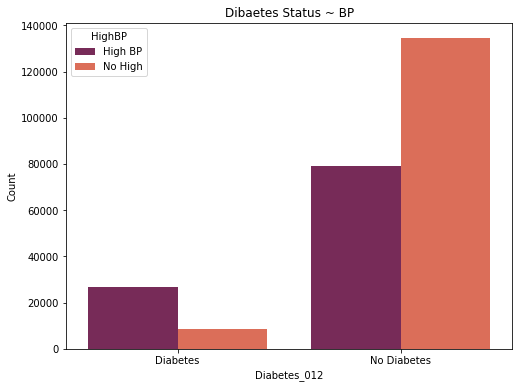

In [47]:
#group diabetes status & BP
dia_bp = eda2.groupby(['Diabetes_012', 'HighBP']).size().reset_index(name = 'Count')
print(dia_bp)

#visualize diabetes status ~ BP
plt.figure(figsize = (8,6))
sns.barplot(x = 'Diabetes_012', y = 'Count', hue = 'HighBP', data = dia_bp, palette="rocket")
plt.title("Dibaetes Status ~ BP")
plt.show()

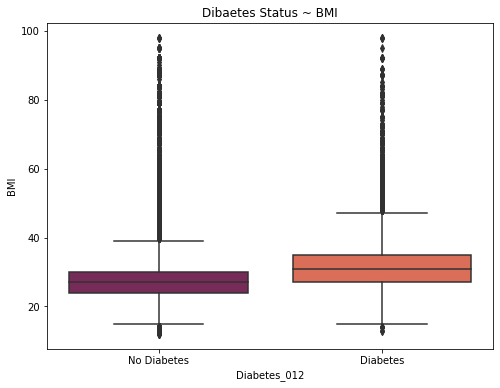

In [48]:
#visualize diabetes status ~ BMI
plt.figure(figsize = (8,6))
sns.boxplot(data = eda2, x = 'Diabetes_012', y = 'BMI', palette="rocket")
plt.title("Dibaetes Status ~ BMI")
plt.show()

  Diabetes_012    GenHlth  Count
0     Diabetes  Excellent   1140
1     Diabetes       fair   9790
2     Diabetes       good  13457
3     Diabetes       poor   4578
4     Diabetes  very good   6381
5  No Diabetes  Excellent  43846
6  No Diabetes       fair  20755
7  No Diabetes       good  60461
8  No Diabetes       poor   7152
9  No Diabetes  very good  81489


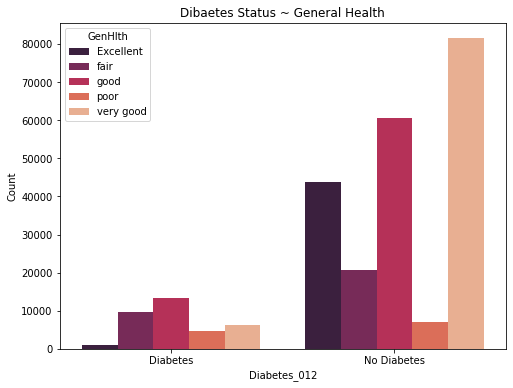

In [49]:
#group diabetes status & general health
diab_genhealth = eda2.groupby(['Diabetes_012', 'GenHlth']).size().reset_index(name = 'Count')
print(diab_genhealth)

#visualize diabetes status ~ general health
plt.figure(figsize = (8,6))
sns.barplot(x = 'Diabetes_012', y = 'Count', hue = 'GenHlth', data = diab_genhealth, palette="rocket")
plt.title("Dibaetes Status ~ General Health")
plt.show()

  Diabetes_012 DiffWalk   Count
0     Diabetes       No   22225
1     Diabetes      yes   13121
2  No Diabetes       No  185434
3  No Diabetes      yes   28269


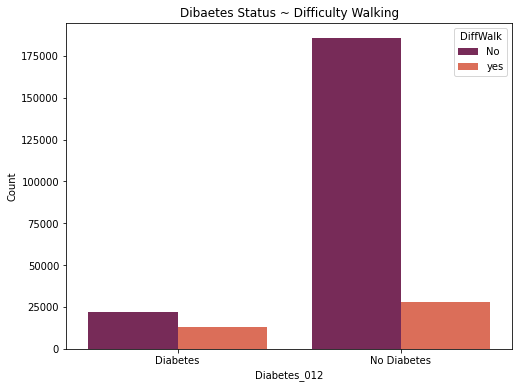

In [50]:
#group diabetes status & difficulty walking
dia_walk = eda2.groupby(['Diabetes_012', 'DiffWalk']).size().reset_index(name = 'Count')
print(dia_walk)

#visualize diabetes status ~ difficulty walking
plt.figure(figsize = (8,6))
sns.barplot(x = 'Diabetes_012', y = 'Count', hue = 'DiffWalk', data = dia_walk, palette="rocket")
plt.title("Dibaetes Status ~ Difficulty Walking")
plt.show()

# Use of SMOTE function to balance dataset

In [51]:
from sklearn.model_selection import train_test_split
X = df2.toPandas().filter(items=['HighBP','HighChol','BMI','GenHlth','DiffWalk'])
Y = df2.toPandas().filter(items=['Diabetes_012'])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=0)

In [52]:
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from collections import Counter
 
sm = SMOTE(random_state=3)
x_train_res, y_train_res = sm.fit_resample(X_train, Y_train)

In [59]:
import pandas as pd
dataframe_1 = pd.DataFrame(x_train_res,columns=['HighBP','HighChol','BMI','GenHlth','DiffWalk'])
dataframe_2 = pd.DataFrame(y_train_res, columns = ['Diabetes_012'])
result = dataframe_1.combine_first(dataframe_2)
smote_1 = spark.createDataFrame(result)

21/12/08 17:03:41 WARN TaskSetManager: Stage 128 contains a task of very large size (2684 KiB). The maximum recommended task size is 1000 KiB.


[192322, 192322]


([<matplotlib.axis.XTick at 0x7fbdfcb82970>,
 [Text(0, 0, '0.0'), Text(1, 0, '1.0')])

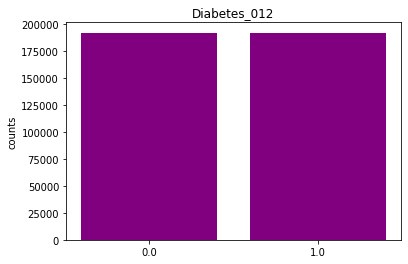

In [60]:
import matplotlib.pyplot as plt
import numpy as np
responses = smote_1.groupBy('Diabetes_012').count().collect()
categories = [i[0] for i in responses]
counts = [i[1] for i in responses]
print(counts)
ind = np.array(range(len(categories)))
width = 0.35
plt.bar (ind, counts, color='purple')
plt.ylabel('counts' )
plt.title('Diabetes_012')
plt.xticks (ind, categories)

In [62]:
print((smote_1.count(),len(imputeDF_1.columns)))
smote_1.groupby('Diabetes_012').count().show()

21/12/08 17:03:58 WARN TaskSetManager: Stage 134 contains a task of very large size (2684 KiB). The maximum recommended task size is 1000 KiB.


(384644, 6)


21/12/08 17:03:58 WARN TaskSetManager: Stage 137 contains a task of very large size (2684 KiB). The maximum recommended task size is 1000 KiB.


+------------+------+
|Diabetes_012| count|
+------------+------+
|         0.0|192322|
|         1.0|192322|
+------------+------+



In [63]:
smote_1.show()

+----+------------+--------+-------+------+--------+
| BMI|Diabetes_012|DiffWalk|GenHlth|HighBP|HighChol|
+----+------------+--------+-------+------+--------+
|24.0|         0.0|     0.0|    2.0|   1.0|     0.0|
|25.0|         0.0|     0.0|    1.0|   0.0|     0.0|
|27.0|         0.0|     0.0|    2.0|   0.0|     0.0|
|53.0|         0.0|     1.0|    3.0|   1.0|     0.0|
|33.0|         0.0|     1.0|    3.0|   1.0|     1.0|
|31.0|         0.0|     0.0|    3.0|   1.0|     1.0|
|26.0|         0.0|     0.0|    1.0|   0.0|     0.0|
|35.0|         0.0|     0.0|    1.0|   0.0|     0.0|
|27.0|         0.0|     0.0|    3.0|   0.0|     0.0|
|35.0|         1.0|     0.0|    2.0|   1.0|     1.0|
|30.0|         0.0|     1.0|    3.0|   1.0|     0.0|
|26.0|         0.0|     0.0|    4.0|   1.0|     0.0|
|19.0|         0.0|     0.0|    2.0|   0.0|     1.0|
|23.0|         0.0|     0.0|    2.0|   0.0|     0.0|
|46.0|         0.0|     0.0|    3.0|   1.0|     0.0|
|27.0|         0.0|     0.0|    1.0|   0.0|   

21/12/08 17:04:03 WARN TaskSetManager: Stage 140 contains a task of very large size (2684 KiB). The maximum recommended task size is 1000 KiB.


In [64]:
from pyspark.ml.feature import VectorAssembler,MinMaxScaler
assembler_smote = VectorAssembler(inputCols=['HighBP','HighChol','BMI','GenHlth','DiffWalk'], outputCol='features')
output_data_smote = assembler_smote.transform(smote_1)
output_data_smote.groupby('Diabetes_012').count().show()

21/12/08 17:04:35 WARN TaskSetManager: Stage 141 contains a task of very large size (2684 KiB). The maximum recommended task size is 1000 KiB.


+------------+------+
|Diabetes_012| count|
+------------+------+
|         0.0|192322|
|         1.0|192322|
+------------+------+



In [65]:
minmax_scaler = MinMaxScaler(inputCol="features", outputCol="scaled")
output1_data_smote = minmax_scaler.fit(output_data_smote).transform(output_data_smote)
output1_data_smote.show(5)

21/12/08 17:05:01 WARN TaskSetManager: Stage 144 contains a task of very large size (2684 KiB). The maximum recommended task size is 1000 KiB.


+----+------------+--------+-------+------+--------+--------------------+--------------------+
| BMI|Diabetes_012|DiffWalk|GenHlth|HighBP|HighChol|            features|              scaled|
+----+------------+--------+-------+------+--------+--------------------+--------------------+
|24.0|         0.0|     0.0|    2.0|   1.0|     0.0|[1.0,0.0,24.0,2.0...|[1.0,0.0,0.139534...|
|25.0|         0.0|     0.0|    1.0|   0.0|     0.0|(5,[2,3],[25.0,1.0])|(5,[2],[0.1511627...|
|27.0|         0.0|     0.0|    2.0|   0.0|     0.0|(5,[2,3],[27.0,2.0])|(5,[2,3],[0.17441...|
|53.0|         0.0|     1.0|    3.0|   1.0|     0.0|[1.0,0.0,53.0,3.0...|[1.0,0.0,0.476744...|
|33.0|         0.0|     1.0|    3.0|   1.0|     1.0|[1.0,1.0,33.0,3.0...|[1.0,1.0,0.244186...|
+----+------------+--------+-------+------+--------+--------------------+--------------------+
only showing top 5 rows



21/12/08 17:05:03 WARN TaskSetManager: Stage 147 contains a task of very large size (2684 KiB). The maximum recommended task size is 1000 KiB.


In [66]:
# Load training data
final_data = output1_data_smote.select('scaled','Diabetes_012')
final_data.show()

+--------------------+------------+
|              scaled|Diabetes_012|
+--------------------+------------+
|[1.0,0.0,0.139534...|         0.0|
|(5,[2],[0.1511627...|         0.0|
|(5,[2,3],[0.17441...|         0.0|
|[1.0,0.0,0.476744...|         0.0|
|[1.0,1.0,0.244186...|         0.0|
|[1.0,1.0,0.220930...|         0.0|
|(5,[2],[0.1627906...|         0.0|
|(5,[2],[0.2674418...|         0.0|
|(5,[2,3],[0.17441...|         0.0|
|[1.0,1.0,0.267441...|         1.0|
|[1.0,0.0,0.209302...|         0.0|
|[1.0,0.0,0.162790...|         0.0|
|[0.0,1.0,0.081395...|         0.0|
|(5,[2,3],[0.12790...|         0.0|
|[1.0,0.0,0.395348...|         0.0|
|(5,[2],[0.1744186...|         0.0|
|(5,[2,3],[0.23255...|         0.0|
|(5,[2,3],[0.09302...|         0.0|
|(5,[2],[0.2441860...|         0.0|
|[1.0,0.0,0.290697...|         0.0|
+--------------------+------------+
only showing top 20 rows



21/12/08 17:05:20 WARN TaskSetManager: Stage 148 contains a task of very large size (2684 KiB). The maximum recommended task size is 1000 KiB.


# Logistic Regression

21/12/08 17:29:15 WARN TaskSetManager: Stage 1226 contains a task of very large size (2684 KiB). The maximum recommended task size is 1000 KiB.
21/12/08 17:29:17 WARN TaskSetManager: Stage 1228 contains a task of very large size (2684 KiB). The maximum recommended task size is 1000 KiB.
21/12/08 17:29:17 WARN TaskSetManager: Stage 1230 contains a task of very large size (2684 KiB). The maximum recommended task size is 1000 KiB.
21/12/08 17:29:18 WARN TaskSetManager: Stage 1232 contains a task of very large size (2684 KiB). The maximum recommended task size is 1000 KiB.
21/12/08 17:29:18 WARN TaskSetManager: Stage 1234 contains a task of very large size (2684 KiB). The maximum recommended task size is 1000 KiB.
21/12/08 17:29:18 WARN TaskSetManager: Stage 1236 contains a task of very large size (2684 KiB). The maximum recommended task size is 1000 KiB.
21/12/08 17:29:18 WARN TaskSetManager: Stage 1238 contains a task of very large size (2684 KiB). The maximum recommended task size is 10

+-------+------------------+------------------+
|summary|      Diabetes_012|        prediction|
+-------+------------------+------------------+
|  count|            269108|            269108|
|   mean|0.5000222958812075|0.5102969811376845|
| stddev|0.5000009285005321|0.4998948897357867|
|    min|               0.0|               0.0|
|    max|               1.0|               1.0|
+-------+------------------+------------------+



21/12/08 17:29:23 WARN TaskSetManager: Stage 1251 contains a task of very large size (2684 KiB). The maximum recommended task size is 1000 KiB.


+--------------------+------------+--------------------+--------------------+----------+
|              scaled|Diabetes_012|       rawPrediction|         probability|prediction|
+--------------------+------------+--------------------+--------------------+----------+
|(5,[0,2],[1.0,0.0...|         0.0|[1.99903146435677...|[0.88069535043736...|       0.0|
|(5,[0,2],[1.0,0.0...|         0.0|[1.93711498534509...|[0.87403485195260...|       0.0|
|(5,[0,2],[1.0,0.0...|         0.0|[1.81328202732171...|[0.85975806930599...|       0.0|
|(5,[0,2],[1.0,0.0...|         0.0|[1.75136554831003...|[0.85212495475375...|       0.0|
|(5,[0,2],[1.0,0.0...|         0.0|[1.75136554831003...|[0.85212495475375...|       0.0|
|(5,[0,2],[1.0,0.0...|         0.0|[1.68944906929834...|[0.84415169338868...|       0.0|
|(5,[0,2],[1.0,0.0...|         0.0|[1.68944906929834...|[0.84415169338868...|       0.0|
|(5,[0,2],[1.0,0.0...|         0.0|[1.68944906929834...|[0.84415169338868...|       0.0|
|(5,[0,2],[1.0,0.0...

21/12/08 17:29:23 WARN TaskSetManager: Stage 1252 contains a task of very large size (2684 KiB). The maximum recommended task size is 1000 KiB.
21/12/08 17:29:24 WARN TaskSetManager: Stage 1253 contains a task of very large size (2684 KiB). The maximum recommended task size is 1000 KiB.


              precision    recall  f1-score   support

         0.0       0.74      0.73      0.73     57774
         1.0       0.73      0.74      0.74     57762

    accuracy                           0.73    115536
   macro avg       0.73      0.73      0.73    115536
weighted avg       0.73      0.73      0.73    115536



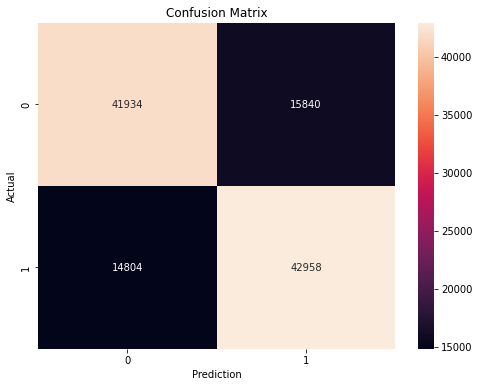

In [74]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from sklearn.metrics import classification_report, confusion_matrix
train , test = final_data.randomSplit([0.7,0.3])
models = LogisticRegression(labelCol='Diabetes_012',featuresCol="scaled")
model = models.fit(train)
summary = model.summary
summary.predictions.describe().show()
predictions = model.evaluate(test)
predictions.predictions.show(20)
#evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="Diabetes_012")
#evaluator.evaluate(model.transform(test))

y_true = predictions.predictions.select(['Diabetes_012']).collect()
y_pred = predictions.predictions.select(['prediction']).collect()

print(classification_report(y_true, y_pred))
plt.figure(figsize = (8,6))
sns.heatmap(confusion_matrix(y_true, y_pred), annot = True, fmt = ".0f")
plt.title("Confusion Matrix")
plt.xlabel("Prediction")
plt.ylabel("Actual")
plt.show()

# Random Forest Classifer

21/12/08 17:29:30 WARN TaskSetManager: Stage 1254 contains a task of very large size (2684 KiB). The maximum recommended task size is 1000 KiB.
21/12/08 17:29:31 WARN TaskSetManager: Stage 1257 contains a task of very large size (2684 KiB). The maximum recommended task size is 1000 KiB.
21/12/08 17:29:32 WARN TaskSetManager: Stage 1258 contains a task of very large size (2684 KiB). The maximum recommended task size is 1000 KiB.
21/12/08 17:29:33 WARN TaskSetManager: Stage 1259 contains a task of very large size (2684 KiB). The maximum recommended task size is 1000 KiB.
21/12/08 17:29:34 WARN TaskSetManager: Stage 1261 contains a task of very large size (2684 KiB). The maximum recommended task size is 1000 KiB.
21/12/08 17:29:36 WARN TaskSetManager: Stage 1263 contains a task of very large size (2684 KiB). The maximum recommended task size is 1000 KiB.
21/12/08 17:29:36 WARN TaskSetManager: Stage 1265 contains a task of very large size (2684 KiB). The maximum recommended task size is 10

+-------+------------------+-------------------+
|summary|      Diabetes_012|         prediction|
+-------+------------------+-------------------+
|  count|            269205|             269205|
|   mean|0.5005441949443733| 0.5359187236492635|
| stddev|0.5000006325141266|0.49870910274697416|
|    min|               0.0|                0.0|
|    max|               1.0|                1.0|
+-------+------------------+-------------------+



21/12/08 17:29:40 WARN TaskSetManager: Stage 1274 contains a task of very large size (2684 KiB). The maximum recommended task size is 1000 KiB.


+--------------------+------------+--------------------+--------------------+----------+
|              scaled|Diabetes_012|       rawPrediction|         probability|prediction|
+--------------------+------------+--------------------+--------------------+----------+
|(5,[0,2],[1.0,0.0...|         0.0|[13.1508304848457...|[0.65754152424228...|       0.0|
|(5,[0,2],[1.0,0.0...|         0.0|[13.1508304848457...|[0.65754152424228...|       0.0|
|(5,[0,2],[1.0,0.0...|         0.0|[13.1508304848457...|[0.65754152424228...|       0.0|
|(5,[0,2],[1.0,0.0...|         0.0|[13.1508304848457...|[0.65754152424228...|       0.0|
|(5,[0,2],[1.0,0.1...|         0.0|[13.1508304848457...|[0.65754152424228...|       0.0|
|(5,[0,2],[1.0,0.1...|         0.0|[13.1508304848457...|[0.65754152424228...|       0.0|
|(5,[0,2],[1.0,0.1...|         0.0|[13.1508304848457...|[0.65754152424228...|       0.0|
|(5,[0,2],[1.0,0.1...|         0.0|[13.1508304848457...|[0.65754152424228...|       0.0|
|(5,[0,2],[1.0,0.1...

21/12/08 17:29:41 WARN TaskSetManager: Stage 1275 contains a task of very large size (2684 KiB). The maximum recommended task size is 1000 KiB.
21/12/08 17:29:42 WARN TaskSetManager: Stage 1276 contains a task of very large size (2684 KiB). The maximum recommended task size is 1000 KiB.


              precision    recall  f1-score   support

         0.0       0.75      0.70      0.73     57866
         1.0       0.72      0.77      0.74     57573

    accuracy                           0.73    115439
   macro avg       0.74      0.74      0.73    115439
weighted avg       0.74      0.73      0.73    115439



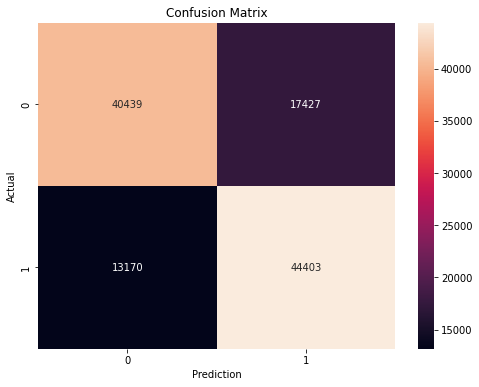

In [75]:
from pyspark.ml.classification import RandomForestClassifier

train , test = final_data.randomSplit([0.7,0.3])
model_rf = RandomForestClassifier(labelCol='Diabetes_012',featuresCol="scaled")
model_rf = model_rf.fit(train)
summary = model_rf.summary
summary.predictions.describe().show()
predictions = model_rf.evaluate(test)
predictions.predictions.show(20)
#evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="Diabetes_012")
#evaluator.evaluate(model.transform(test))

y_true = predictions.predictions.select(['Diabetes_012']).collect()
y_pred = predictions.predictions.select(['prediction']).collect()

print(classification_report(y_true, y_pred))
plt.figure(figsize = (8,6))
sns.heatmap(confusion_matrix(y_true, y_pred), annot = True, fmt = ".0f")
plt.title("Confusion Matrix")
plt.xlabel("Prediction")
plt.ylabel("Actual")
plt.show()

# Gradient Boosting Tree

21/12/08 17:28:47 WARN TaskSetManager: Stage 1019 contains a task of very large size (2684 KiB). The maximum recommended task size is 1000 KiB.
21/12/08 17:28:47 WARN TaskSetManager: Stage 1020 contains a task of very large size (2684 KiB). The maximum recommended task size is 1000 KiB.
21/12/08 17:28:48 WARN TaskSetManager: Stage 1021 contains a task of very large size (2684 KiB). The maximum recommended task size is 1000 KiB.
21/12/08 17:28:50 WARN TaskSetManager: Stage 1023 contains a task of very large size (2684 KiB). The maximum recommended task size is 1000 KiB.
21/12/08 17:28:51 WARN TaskSetManager: Stage 1025 contains a task of very large size (2684 KiB). The maximum recommended task size is 1000 KiB.
21/12/08 17:28:51 WARN TaskSetManager: Stage 1027 contains a task of very large size (2684 KiB). The maximum recommended task size is 1000 KiB.
21/12/08 17:28:51 WARN TaskSetManager: Stage 1029 contains a task of very large size (2684 KiB). The maximum recommended task size is 10

21/12/08 17:28:59 WARN TaskSetManager: Stage 1133 contains a task of very large size (2685 KiB). The maximum recommended task size is 1000 KiB.
21/12/08 17:28:59 WARN TaskSetManager: Stage 1135 contains a task of very large size (2685 KiB). The maximum recommended task size is 1000 KiB.
21/12/08 17:28:59 WARN TaskSetManager: Stage 1137 contains a task of very large size (2685 KiB). The maximum recommended task size is 1000 KiB.
21/12/08 17:28:59 WARN TaskSetManager: Stage 1139 contains a task of very large size (2685 KiB). The maximum recommended task size is 1000 KiB.
21/12/08 17:28:59 WARN TaskSetManager: Stage 1141 contains a task of very large size (2685 KiB). The maximum recommended task size is 1000 KiB.
21/12/08 17:28:59 WARN TaskSetManager: Stage 1143 contains a task of very large size (2685 KiB). The maximum recommended task size is 1000 KiB.
21/12/08 17:28:59 WARN TaskSetManager: Stage 1145 contains a task of very large size (2685 KiB). The maximum recommended task size is 10

+--------------------+------------+--------------------+--------------------+----------+
|              scaled|Diabetes_012|       rawPrediction|         probability|prediction|
+--------------------+------------+--------------------+--------------------+----------+
|(5,[0,2],[1.0,0.0...|         0.0|[1.10378907818018...|[0.90092797069540...|       0.0|
|(5,[0,2],[1.0,0.0...|         0.0|[1.10378907818018...|[0.90092797069540...|       0.0|
|(5,[0,2],[1.0,0.0...|         0.0|[1.10378907818018...|[0.90092797069540...|       0.0|
|(5,[0,2],[1.0,0.0...|         0.0|[1.10378907818018...|[0.90092797069540...|       0.0|
|(5,[0,2],[1.0,0.0...|         0.0|[1.10378907818018...|[0.90092797069540...|       0.0|
|(5,[0,2],[1.0,0.0...|         0.0|[1.10378907818018...|[0.90092797069540...|       0.0|
|(5,[0,2],[1.0,0.0...|         0.0|[1.10378907818018...|[0.90092797069540...|       0.0|
|(5,[0,2],[1.0,0.1...|         0.0|[1.02150977580371...|[0.88524038076299...|       0.0|
|(5,[0,2],[1.0,0.1...

21/12/08 17:29:07 WARN TaskSetManager: Stage 1224 contains a task of very large size (2684 KiB). The maximum recommended task size is 1000 KiB.
21/12/08 17:29:09 WARN TaskSetManager: Stage 1225 contains a task of very large size (2684 KiB). The maximum recommended task size is 1000 KiB.


              precision    recall  f1-score   support

         0.0       0.75      0.71      0.73     57470
         1.0       0.73      0.77      0.75     57717

    accuracy                           0.74    115187
   macro avg       0.74      0.74      0.74    115187
weighted avg       0.74      0.74      0.74    115187



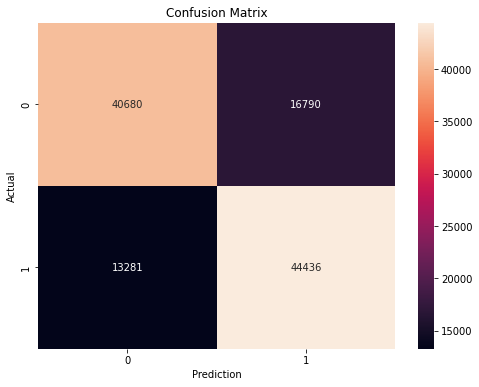

In [73]:
from pyspark.ml.classification import GBTClassifier

train , test = final_data.randomSplit([0.7,0.3])

models_gbt = GBTClassifier(labelCol='Diabetes_012',featuresCol="scaled")
model_gbt = models_gbt.fit(train)
predictions = model_gbt.transform(test)
predictions.show(20)
#evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="Diabetes_012")
#evaluator.evaluate(model.transform(test))

y_true = predictions.select(['Diabetes_012']).collect()
y_pred = predictions.select(['prediction']).collect()

print(classification_report(y_true, y_pred))
plt.figure(figsize = (8,6))
sns.heatmap(confusion_matrix(y_true, y_pred), annot = True, fmt = ".0f")
plt.title("Confusion Matrix")
plt.xlabel("Prediction")
plt.ylabel("Actual")
plt.show()

# Evaluation of performance runtime

## Logistic Regression  runtime evaluation

In [77]:
import time
start = time.time()

train , test = final_data.randomSplit([0.7,0.3])
models = LogisticRegression(labelCol='Diabetes_012',featuresCol="scaled")
model = models.fit(train)
summary = model.summary
summary.predictions.describe().show()
predictions = model.evaluate(test)
end = time.time()
predictions.predictions.show(20)

timetaken = end - start
print("Time taken to run the Linear Regression model:", timetaken )

21/12/08 17:34:08 WARN TaskSetManager: Stage 1303 contains a task of very large size (2684 KiB). The maximum recommended task size is 1000 KiB.
21/12/08 17:34:09 WARN TaskSetManager: Stage 1305 contains a task of very large size (2684 KiB). The maximum recommended task size is 1000 KiB.
21/12/08 17:34:11 WARN TaskSetManager: Stage 1307 contains a task of very large size (2684 KiB). The maximum recommended task size is 1000 KiB.
21/12/08 17:34:11 WARN TaskSetManager: Stage 1309 contains a task of very large size (2684 KiB). The maximum recommended task size is 1000 KiB.
21/12/08 17:34:11 WARN TaskSetManager: Stage 1311 contains a task of very large size (2684 KiB). The maximum recommended task size is 1000 KiB.
21/12/08 17:34:11 WARN TaskSetManager: Stage 1313 contains a task of very large size (2684 KiB). The maximum recommended task size is 1000 KiB.
21/12/08 17:34:11 WARN TaskSetManager: Stage 1315 contains a task of very large size (2684 KiB). The maximum recommended task size is 10

+-------+------------------+------------------+
|summary|      Diabetes_012|        prediction|
+-------+------------------+------------------+
|  count|            268967|            268967|
|   mean| 0.500150576092978|0.5090736038250046|
| stddev|0.5000009068114447|0.4999185922658198|
|    min|               0.0|               0.0|
|    max|               1.0|               1.0|
+-------+------------------+------------------+



21/12/08 17:34:14 WARN TaskSetManager: Stage 1328 contains a task of very large size (2684 KiB). The maximum recommended task size is 1000 KiB.


+--------------------+------------+--------------------+--------------------+----------+
|              scaled|Diabetes_012|       rawPrediction|         probability|prediction|
+--------------------+------------+--------------------+--------------------+----------+
|(5,[0,2],[1.0,0.0...|         0.0|[1.92375382331038...|[0.87255644929344...|       0.0|
|(5,[0,2],[1.0,0.0...|         0.0|[1.80072040788416...|[0.85823660725161...|       0.0|
|(5,[0,2],[1.0,0.0...|         0.0|[1.80072040788416...|[0.85823660725161...|       0.0|
|(5,[0,2],[1.0,0.0...|         0.0|[1.73920370017106...|[0.85058589234649...|       0.0|
|(5,[0,2],[1.0,0.0...|         0.0|[1.73920370017106...|[0.85058589234649...|       0.0|
|(5,[0,2],[1.0,0.0...|         0.0|[1.67768699245795...|[0.84259800781226...|       0.0|
|(5,[0,2],[1.0,0.0...|         0.0|[1.67768699245795...|[0.84259800781226...|       0.0|
|(5,[0,2],[1.0,0.0...|         0.0|[1.67768699245795...|[0.84259800781226...|       0.0|
|(5,[0,2],[1.0,0.1...

## Random Forest runtime evaluation

In [81]:
import time
start = time.time()

train , test = final_data.randomSplit([0.7,0.3])
models = RandomForestClassifier(labelCol='Diabetes_012',featuresCol="scaled")
model = models.fit(train)
summary = model.summary
summary.predictions.describe().show()
predictions = model.evaluate(test)
end = time.time()
predictions.predictions.show(20)

timetaken = end - start
print("Time taken to run the Random Forest model:", timetaken )

21/12/08 17:36:16 WARN TaskSetManager: Stage 1350 contains a task of very large size (2684 KiB). The maximum recommended task size is 1000 KiB.
21/12/08 17:36:17 WARN TaskSetManager: Stage 1353 contains a task of very large size (2684 KiB). The maximum recommended task size is 1000 KiB.
21/12/08 17:36:17 WARN TaskSetManager: Stage 1354 contains a task of very large size (2684 KiB). The maximum recommended task size is 1000 KiB.
21/12/08 17:36:18 WARN TaskSetManager: Stage 1355 contains a task of very large size (2684 KiB). The maximum recommended task size is 1000 KiB.
21/12/08 17:36:19 WARN TaskSetManager: Stage 1357 contains a task of very large size (2684 KiB). The maximum recommended task size is 1000 KiB.
21/12/08 17:36:20 WARN TaskSetManager: Stage 1359 contains a task of very large size (2684 KiB). The maximum recommended task size is 1000 KiB.
21/12/08 17:36:21 WARN TaskSetManager: Stage 1361 contains a task of very large size (2684 KiB). The maximum recommended task size is 10

+-------+-------------------+-------------------+
|summary|       Diabetes_012|         prediction|
+-------+-------------------+-------------------+
|  count|             269304|             269304|
|   mean|0.49955440691560465|  0.546148590440543|
| stddev| 0.5000007297679064|0.49786667694731357|
|    min|                0.0|                0.0|
|    max|                1.0|                1.0|
+-------+-------------------+-------------------+



21/12/08 17:36:24 WARN TaskSetManager: Stage 1370 contains a task of very large size (2684 KiB). The maximum recommended task size is 1000 KiB.


+--------------------+------------+--------------------+--------------------+----------+
|              scaled|Diabetes_012|       rawPrediction|         probability|prediction|
+--------------------+------------+--------------------+--------------------+----------+
|(5,[0,2],[1.0,0.0...|         0.0|[13.0748788727381...|[0.65374394363690...|       0.0|
|(5,[0,2],[1.0,0.0...|         0.0|[13.0748788727381...|[0.65374394363690...|       0.0|
|(5,[0,2],[1.0,0.0...|         0.0|[13.0748788727381...|[0.65374394363690...|       0.0|
|(5,[0,2],[1.0,0.0...|         0.0|[13.0748788727381...|[0.65374394363690...|       0.0|
|(5,[0,2],[1.0,0.0...|         0.0|[13.0748788727381...|[0.65374394363690...|       0.0|
|(5,[0,2],[1.0,0.0...|         0.0|[13.0748788727381...|[0.65374394363690...|       0.0|
|(5,[0,2],[1.0,0.0...|         0.0|[13.0748788727381...|[0.65374394363690...|       0.0|
|(5,[0,2],[1.0,0.0...|         0.0|[13.0748788727381...|[0.65374394363690...|       0.0|
|(5,[0,2],[1.0,0.0...

In [84]:
import time
start = time.time()

train , test = final_data.randomSplit([0.7,0.3])
models = GBTClassifier(labelCol='Diabetes_012',featuresCol="scaled")
model = models.fit(train)
#summary = model.summary
#summary.predictions.describe().show()
predictions = model.transform(test)
end = time.time()
predictions.show(20)

timetaken = end - start
print("Time taken to run the Random Forest model:", timetaken )

21/12/08 17:47:55 WARN TaskSetManager: Stage 1779 contains a task of very large size (2684 KiB). The maximum recommended task size is 1000 KiB.
21/12/08 17:47:55 WARN TaskSetManager: Stage 1780 contains a task of very large size (2684 KiB). The maximum recommended task size is 1000 KiB.
21/12/08 17:47:56 WARN TaskSetManager: Stage 1781 contains a task of very large size (2684 KiB). The maximum recommended task size is 1000 KiB.
21/12/08 17:47:57 WARN TaskSetManager: Stage 1783 contains a task of very large size (2684 KiB). The maximum recommended task size is 1000 KiB.
21/12/08 17:47:58 WARN TaskSetManager: Stage 1785 contains a task of very large size (2684 KiB). The maximum recommended task size is 1000 KiB.
21/12/08 17:47:58 WARN TaskSetManager: Stage 1787 contains a task of very large size (2684 KiB). The maximum recommended task size is 1000 KiB.
21/12/08 17:47:58 WARN TaskSetManager: Stage 1789 contains a task of very large size (2684 KiB). The maximum recommended task size is 10

21/12/08 17:48:04 WARN TaskSetManager: Stage 1891 contains a task of very large size (2685 KiB). The maximum recommended task size is 1000 KiB.
21/12/08 17:48:04 WARN TaskSetManager: Stage 1893 contains a task of very large size (2685 KiB). The maximum recommended task size is 1000 KiB.
21/12/08 17:48:05 WARN TaskSetManager: Stage 1895 contains a task of very large size (2685 KiB). The maximum recommended task size is 1000 KiB.
21/12/08 17:48:05 WARN TaskSetManager: Stage 1897 contains a task of very large size (2685 KiB). The maximum recommended task size is 1000 KiB.
21/12/08 17:48:05 WARN TaskSetManager: Stage 1899 contains a task of very large size (2685 KiB). The maximum recommended task size is 1000 KiB.
21/12/08 17:48:06 WARN TaskSetManager: Stage 1901 contains a task of very large size (2685 KiB). The maximum recommended task size is 1000 KiB.
21/12/08 17:48:06 WARN TaskSetManager: Stage 1903 contains a task of very large size (2685 KiB). The maximum recommended task size is 10

+--------------------+------------+--------------------+--------------------+----------+
|              scaled|Diabetes_012|       rawPrediction|         probability|prediction|
+--------------------+------------+--------------------+--------------------+----------+
|(5,[0,2],[1.0,0.0...|         0.0|[1.17784917857509...|[0.91338609882549...|       0.0|
|(5,[0,2],[1.0,0.0...|         0.0|[1.17784917857509...|[0.91338609882549...|       0.0|
|(5,[0,2],[1.0,0.0...|         0.0|[1.17784917857509...|[0.91338609882549...|       0.0|
|(5,[0,2],[1.0,0.0...|         0.0|[1.17784917857509...|[0.91338609882549...|       0.0|
|(5,[0,2],[1.0,0.0...|         0.0|[1.17784917857509...|[0.91338609882549...|       0.0|
|(5,[0,2],[1.0,0.0...|         0.0|[1.17784917857509...|[0.91338609882549...|       0.0|
|(5,[0,2],[1.0,0.0...|         0.0|[1.17784917857509...|[0.91338609882549...|       0.0|
|(5,[0,2],[1.0,0.0...|         0.0|[1.17784917857509...|[0.91338609882549...|       0.0|
|(5,[0,2],[1.0,0.0...

# Scalability Evaluation

In [86]:
def runtime(df,model_user):
    lr = LogisticRegression(labelCol='Diabetes_012',featuresCol="scaled")
    rfc = RandomForestClassifier(labelCol='Diabetes_012',featuresCol="scaled")
    gbt = GBTClassifier(labelCol='Diabetes_012',featuresCol="scaled")
    
    sampling = [0.25,0.5,0.75,1]
    timeEnd = []
    time = []
    if model_user == "lr":
        for sample in sampling:
            start = timer()
            final_data = output1_data_smote.select('scaled','Diabetes_012')
            final_data.show()
            train , test = final_data.randomSplit([0.7,0.3])
            t = train.count() * sample
            train = train.limit(int(t))
            models = lr
            model = models.fit(train)
            #predictions = model.evaluate(test)
            predictions = model.transform(test)
            end = timer()
            final = end-start
            time.append(final)
            timeEnd.append(end)
    elif model_user == "rfc":
        for sample in sampling:
            start = timer()
            final_data = output1_data_smote.select('scaled','Diabetes_012')
            final_data.show()
            train , test = final_data.randomSplit([0.7,0.3])
            t = train.count() * sample
            train = train.limit(int(t))
            models = rfc
            model = models.fit(train)
            #predictions = model.evaluate(test)
            predictions = model.transform(test)
            end = timer()
            final = end-start
            time.append(final)
            timeEnd.append(end)
    elif model_user == "gbt":
        for sample in sampling:
            start = timer()
            final_data = output1_data_smote.select('scaled','Diabetes_012')
            final_data.show()
            train , test = final_data.randomSplit([0.7,0.3])
            t = train.count() * sample
            train = train.limit(int(t))
            models = lr
            model = models.fit(train)
            #predictions = model.evaluate(test)
            predictions = model.transform(test)
            end = timer()
            final = end-start
            time.append(final)
            timeEnd.append(end)
        
        
    return sampling, time

In [91]:
from timeit import default_timer as timer
sample, time = runtime(final_data,model_user="lr")
print(sample)
print(time)

21/12/08 18:03:07 WARN TaskSetManager: Stage 2108 contains a task of very large size (2684 KiB). The maximum recommended task size is 1000 KiB.


+--------------------+------------+
|              scaled|Diabetes_012|
+--------------------+------------+
|[1.0,0.0,0.139534...|         0.0|
|(5,[2],[0.1511627...|         0.0|
|(5,[2,3],[0.17441...|         0.0|
|[1.0,0.0,0.476744...|         0.0|
|[1.0,1.0,0.244186...|         0.0|
|[1.0,1.0,0.220930...|         0.0|
|(5,[2],[0.1627906...|         0.0|
|(5,[2],[0.2674418...|         0.0|
|(5,[2,3],[0.17441...|         0.0|
|[1.0,1.0,0.267441...|         1.0|
|[1.0,0.0,0.209302...|         0.0|
|[1.0,0.0,0.162790...|         0.0|
|[0.0,1.0,0.081395...|         0.0|
|(5,[2,3],[0.12790...|         0.0|
|[1.0,0.0,0.395348...|         0.0|
|(5,[2],[0.1744186...|         0.0|
|(5,[2,3],[0.23255...|         0.0|
|(5,[2,3],[0.09302...|         0.0|
|(5,[2],[0.2441860...|         0.0|
|[1.0,0.0,0.290697...|         0.0|
+--------------------+------------+
only showing top 20 rows



21/12/08 18:03:08 WARN TaskSetManager: Stage 2109 contains a task of very large size (2684 KiB). The maximum recommended task size is 1000 KiB.
21/12/08 18:03:10 WARN TaskSetManager: Stage 2112 contains a task of very large size (2684 KiB). The maximum recommended task size is 1000 KiB.
21/12/08 18:03:11 WARN TaskSetManager: Stage 2113 contains a task of very large size (2684 KiB). The maximum recommended task size is 1000 KiB.
21/12/08 18:03:14 WARN TaskSetManager: Stage 2138 contains a task of very large size (2684 KiB). The maximum recommended task size is 1000 KiB.
21/12/08 18:03:14 WARN TaskSetManager: Stage 2139 contains a task of very large size (2684 KiB). The maximum recommended task size is 1000 KiB.
21/12/08 18:03:15 WARN TaskSetManager: Stage 2140 contains a task of very large size (2684 KiB). The maximum recommended task size is 1000 KiB.


+--------------------+------------+
|              scaled|Diabetes_012|
+--------------------+------------+
|[1.0,0.0,0.139534...|         0.0|
|(5,[2],[0.1511627...|         0.0|
|(5,[2,3],[0.17441...|         0.0|
|[1.0,0.0,0.476744...|         0.0|
|[1.0,1.0,0.244186...|         0.0|
|[1.0,1.0,0.220930...|         0.0|
|(5,[2],[0.1627906...|         0.0|
|(5,[2],[0.2674418...|         0.0|
|(5,[2,3],[0.17441...|         0.0|
|[1.0,1.0,0.267441...|         1.0|
|[1.0,0.0,0.209302...|         0.0|
|[1.0,0.0,0.162790...|         0.0|
|[0.0,1.0,0.081395...|         0.0|
|(5,[2,3],[0.12790...|         0.0|
|[1.0,0.0,0.395348...|         0.0|
|(5,[2],[0.1744186...|         0.0|
|(5,[2,3],[0.23255...|         0.0|
|(5,[2,3],[0.09302...|         0.0|
|(5,[2],[0.2441860...|         0.0|
|[1.0,0.0,0.290697...|         0.0|
+--------------------+------------+
only showing top 20 rows



21/12/08 18:03:16 WARN TaskSetManager: Stage 2141 contains a task of very large size (2684 KiB). The maximum recommended task size is 1000 KiB.
21/12/08 18:03:16 WARN TaskSetManager: Stage 2144 contains a task of very large size (2684 KiB). The maximum recommended task size is 1000 KiB.
21/12/08 18:03:17 WARN TaskSetManager: Stage 2145 contains a task of very large size (2684 KiB). The maximum recommended task size is 1000 KiB.
21/12/08 18:03:22 WARN TaskSetManager: Stage 2170 contains a task of very large size (2684 KiB). The maximum recommended task size is 1000 KiB.
21/12/08 18:03:23 WARN TaskSetManager: Stage 2171 contains a task of very large size (2684 KiB). The maximum recommended task size is 1000 KiB.
21/12/08 18:03:24 WARN TaskSetManager: Stage 2172 contains a task of very large size (2684 KiB). The maximum recommended task size is 1000 KiB.


+--------------------+------------+
|              scaled|Diabetes_012|
+--------------------+------------+
|[1.0,0.0,0.139534...|         0.0|
|(5,[2],[0.1511627...|         0.0|
|(5,[2,3],[0.17441...|         0.0|
|[1.0,0.0,0.476744...|         0.0|
|[1.0,1.0,0.244186...|         0.0|
|[1.0,1.0,0.220930...|         0.0|
|(5,[2],[0.1627906...|         0.0|
|(5,[2],[0.2674418...|         0.0|
|(5,[2,3],[0.17441...|         0.0|
|[1.0,1.0,0.267441...|         1.0|
|[1.0,0.0,0.209302...|         0.0|
|[1.0,0.0,0.162790...|         0.0|
|[0.0,1.0,0.081395...|         0.0|
|(5,[2,3],[0.12790...|         0.0|
|[1.0,0.0,0.395348...|         0.0|
|(5,[2],[0.1744186...|         0.0|
|(5,[2,3],[0.23255...|         0.0|
|(5,[2,3],[0.09302...|         0.0|
|(5,[2],[0.2441860...|         0.0|
|[1.0,0.0,0.290697...|         0.0|
+--------------------+------------+
only showing top 20 rows



21/12/08 18:03:24 WARN TaskSetManager: Stage 2173 contains a task of very large size (2684 KiB). The maximum recommended task size is 1000 KiB.
21/12/08 18:03:25 WARN TaskSetManager: Stage 2176 contains a task of very large size (2684 KiB). The maximum recommended task size is 1000 KiB.
21/12/08 18:03:26 WARN TaskSetManager: Stage 2177 contains a task of very large size (2684 KiB). The maximum recommended task size is 1000 KiB.
21/12/08 18:03:30 WARN TaskSetManager: Stage 2200 contains a task of very large size (2684 KiB). The maximum recommended task size is 1000 KiB.
21/12/08 18:03:32 WARN TaskSetManager: Stage 2201 contains a task of very large size (2684 KiB). The maximum recommended task size is 1000 KiB.
21/12/08 18:03:34 WARN TaskSetManager: Stage 2202 contains a task of very large size (2684 KiB). The maximum recommended task size is 1000 KiB.


+--------------------+------------+
|              scaled|Diabetes_012|
+--------------------+------------+
|[1.0,0.0,0.139534...|         0.0|
|(5,[2],[0.1511627...|         0.0|
|(5,[2,3],[0.17441...|         0.0|
|[1.0,0.0,0.476744...|         0.0|
|[1.0,1.0,0.244186...|         0.0|
|[1.0,1.0,0.220930...|         0.0|
|(5,[2],[0.1627906...|         0.0|
|(5,[2],[0.2674418...|         0.0|
|(5,[2,3],[0.17441...|         0.0|
|[1.0,1.0,0.267441...|         1.0|
|[1.0,0.0,0.209302...|         0.0|
|[1.0,0.0,0.162790...|         0.0|
|[0.0,1.0,0.081395...|         0.0|
|(5,[2,3],[0.12790...|         0.0|
|[1.0,0.0,0.395348...|         0.0|
|(5,[2],[0.1744186...|         0.0|
|(5,[2,3],[0.23255...|         0.0|
|(5,[2,3],[0.09302...|         0.0|
|(5,[2],[0.2441860...|         0.0|
|[1.0,0.0,0.290697...|         0.0|
+--------------------+------------+
only showing top 20 rows



21/12/08 18:03:34 WARN TaskSetManager: Stage 2203 contains a task of very large size (2684 KiB). The maximum recommended task size is 1000 KiB.
21/12/08 18:03:35 WARN TaskSetManager: Stage 2206 contains a task of very large size (2684 KiB). The maximum recommended task size is 1000 KiB.
21/12/08 18:03:36 WARN TaskSetManager: Stage 2207 contains a task of very large size (2684 KiB). The maximum recommended task size is 1000 KiB.
21/12/08 18:03:39 WARN TaskSetManager: Stage 2230 contains a task of very large size (2684 KiB). The maximum recommended task size is 1000 KiB.
21/12/08 18:03:40 WARN TaskSetManager: Stage 2231 contains a task of very large size (2684 KiB). The maximum recommended task size is 1000 KiB.


[0.25, 0.5, 0.75, 1]
[8.187556749999203, 8.379148833000727, 9.713384167000186, 7.978330792000634]


In [93]:
timetaken = []
t = 0
for i in range(len(time)):
    t = t + time[i]
    timetaken.append(t)
timetaken

[8.187556749999203, 16.56670558299993, 26.280089750000116, 34.25842054200075]